## Experimental Predictor

In this notebook, we estimate the parameters of experimental curves using our VAE trained purely on simulated data. We load in saved models. We start by importing all the necessary libraries we need for performing calculations: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch as torch
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import odeint, solve_ivp
import torch.nn as nn
import torch.nn.functional as F

from models.models import VAEMapper, CNNEncoder, CNNDecoder, VAE, MLP

if torch.cuda.is_available():    
    device = "cuda:0"
else:
    device = "cpu"
print(device)

cuda:0


In [39]:
X.shape

(10000, 435)

The first thing we need to do is pull off the min-max scalars from the original simulation process so we normalize and denormalize our datasets. This requires that we read in the data, denormalize it, and then prepare it for computation: 

(10000, 435)


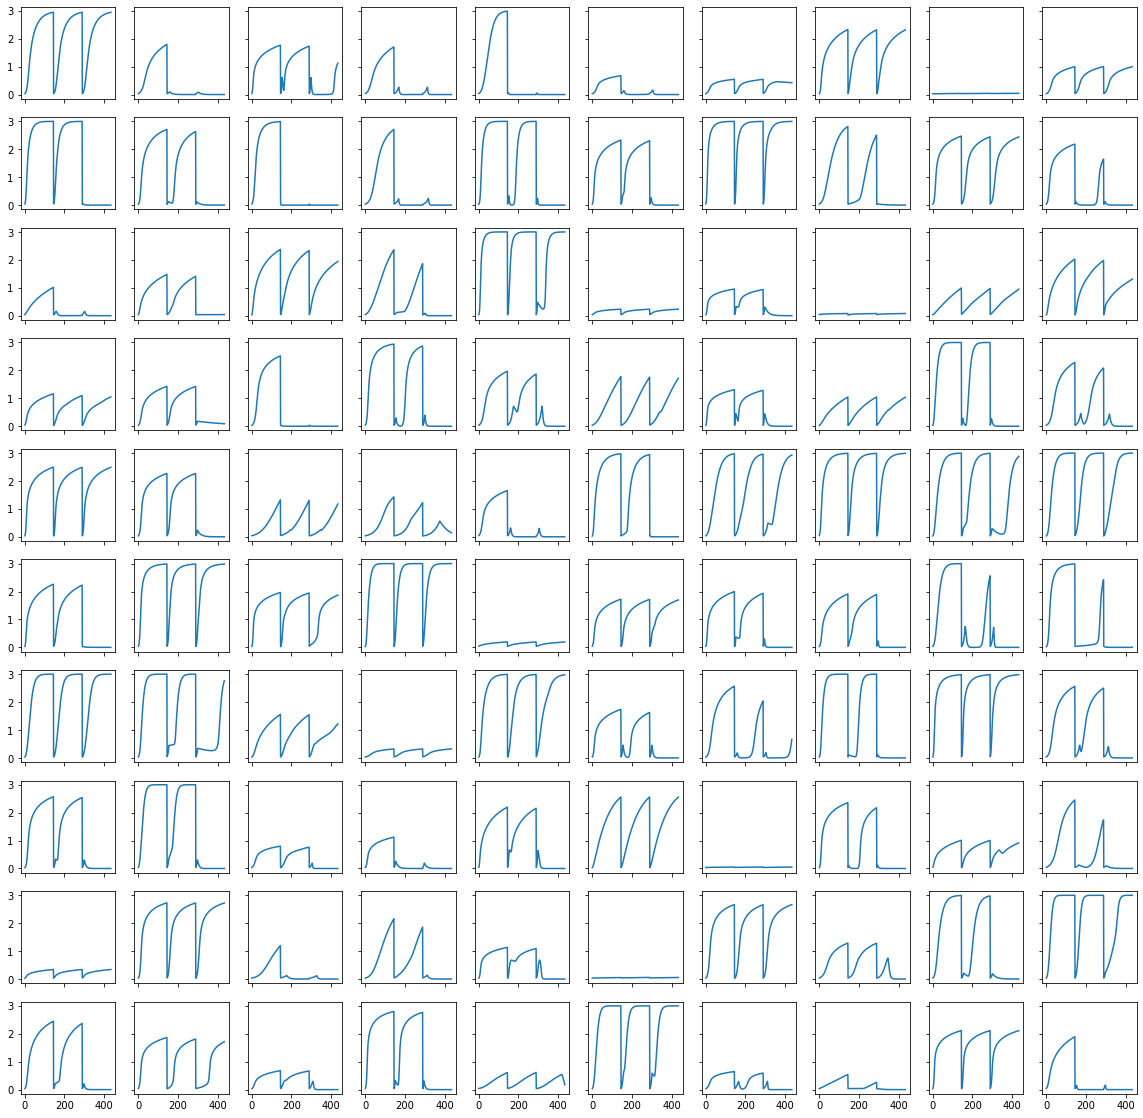

In [43]:
# Define the file path
file_path = 'data/my_curves10k.npy'

# Load in the data
X  = np.load(file_path)[:,:,0,:].reshape(10000,-1)
print(X.shape)

# Plot an example curve
fig, axs = plt.subplots(10,10, figsize = (20,20), sharex = True, sharey= True)
axs = axs.flatten()

for ax in axs:
    j = np.random.randint(X.shape[0])
    ax.plot(X[j,:])
plt.show()

Now let's generate a scaler for later application on the true dataset:

In [3]:
curve_max = X.max()
curve_min = X.min()

curve_scaler = MinMaxScaler()
X_norm =  curve_scaler.fit_transform(X)#(X - curve_min)/(curve_max - curve_min)

Now we will generate a scalar for the labels as well: 

In [4]:
Y = np.load('./data/my_para10k.npy')

# 0 - 1 Normalize
label_scaler = MinMaxScaler()
Y_norm = label_scaler.fit_transform(Y)

In [5]:
from models.models import VAEMapper, CNNEncoder, CNNDecoder,  MLP, VAE

vae = torch.load('./parameters/Initial_Batch/10_128_0.0001_vae.pth').cpu()

Let's now load in our VAE model of interest and then load in the experimental dataset: 

In [6]:

model = torch.load('./models/my_30_mapper.pth').to(device)

Now let's load in our dataset for our system and tranform it to match the scale of the original data:

In [8]:
Z = np.load('./data/avg_OD_all_isolates.npy').reshape(311, -1)

Z_norm = curve_scaler.transform(Z) #(Z - curve_min)/(curve_max - curve_min)

initial_channels = 128
#recon_exp = vae(torch.Tensor(Z_norm).unsqueeze(1).cpu())


Our last step is to basically use our mapper to generate estimated parameters for these systems and then use those parameters to perform forward ODE simulation for our system and verify if our estimated parameters in turn generate dynamics consistent with the data. Let's first define the ODE model for our problem:

In [9]:
def growth(t, y, p, inh):
    n, b, a = np.maximum(y, 0) # ensure values are non-negative
    alpha, Ks, theta, Ln, kappab, phimax, gamma, betamin, db, c = p

    #alpha: max growth rate
    #Ks, theta: tune the shape of growth curves.
    #Nm: carrying capacity.
    #phimax: the maximum antibiotic degradation rate constant by cells (n). 
    #gamma: the maximum normalized lysis rate.
    #betamin (0,1): inversely correlates with Bla-mediated intracellular protection. Larger betamin corresponds to more sensitive cells. 
    #db: the maximum degradation rate constant of Bla mediated by the inhibitor.
    #c(0,1): the ability of the inhibitor to inhibit intracellular Bla. c=0 means that the inhibitor is unable to penetrate and inhibit intracellar Bla.
    
    db0 = 0.001       #basal level degration of Bla
    da0 = 0.001      #basal level degration of antibiotic
    ha = 3          #Hill coefficient of antibiotic-mediated killing.
    Ka = 1          #Michaelis-Menton constant for antibiotic degradation
    Nm = 3.0

    if not hasattr(growth, "initiate_lysis"):
        growth.initiate_lysis = False

    beta = betamin + c * (1 - betamin) if inh > 0 else betamin
    phi = phimax * (1 - c) if inh > 0 else phimax
    
    g = (1/(1 + (n/(Nm*Ks))**theta)) * (1-(n/Nm))  if Ks>0 else 0
    # 
    # this implementation allows the crash and recovery dynamics.
    #
    l = 0
    if a > 0: 
        if not growth.initiate_lysis and n > Ln:        #initiate lysis only when n > Ln. 
            growth.initiate_lysis = True
        if growth.initiate_lysis:
            l = gamma * g * a**ha/(1 + a**ha)            # antibiotic effect is assumed to be binary. Max lysis if a > MIC (=1)
    
    growth_rate = alpha * g * n
    lysis_rate = beta * l * n

    dndt = growth_rate - lysis_rate
    dbdt = lysis_rate - db * b if inh > 0 else lysis_rate - db0 * b  
    dadt = -(kappab * b  + phi * n ) * a/(Ka + a) - da0 * a                    #sensitive cells will have kappab and phimax being small
    return [dndt, dbdt, dadt]

In [10]:
# Run a test example
def simulate(p, n0, a0, inh):
    b0 = 0
    y0 = [n0, b0, a0]
    t = np.linspace(0, 24, 145)
    growth.initiate_lysis=False
    sol = solve_ivp(growth, [t[0], t[-1]], y0, t_eval=t, args=(p, inh), method='LSODA')   #or BDF method
    return sol.y

# Generate experimental prediction
with torch.no_grad():
    predicted_params = model(torch.Tensor(Z_norm).unsqueeze(1).to(device)).cpu().numpy()
# Inverse transform back to proper parameter space
predicted_params = label_scaler.inverse_transform(predicted_params)

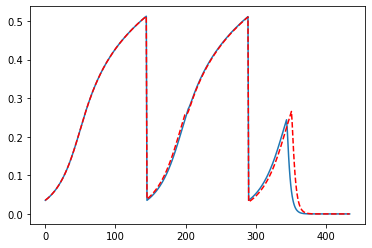

In [11]:
inits = [(0,0),(10,0),(10,10)]

i = np.random.randint(0,311)
p0 = Y[i]
n0 = X[i, 0]

sols = []
for (a0, inh) in inits:
    sol = simulate(p0, n0, a0, inh)
    sols.append(sol[0,:])

sols = np.array(sols).reshape(-1)
plt.plot(sols)
plt.plot(X[i,:], color = 'red', linestyle = '--')
plt.show()

In [12]:
from tqdm.notebook import trange 
# Now simulate with predicted params again true parameters
predictions = []
inits = [(0,0),(10,0),(10,10)]
for i in trange(Z.shape[0]):
    # Get initial conditions
    n0 = Z[i,0]
    
    # Get parameters
    p0 = predicted_params[i]
    sols = []
    for (a0, inh) in inits:
        sol = simulate(p0, n0, a0, inh)
        sols.append(sol[0,:])
    
    sols = np.array(sols).flatten()
    predictions.append(sols)
    
predictions = np.array(predictions)
print(predictions.shape)

  0%|          | 0/311 [00:00<?, ?it/s]

(311, 435)


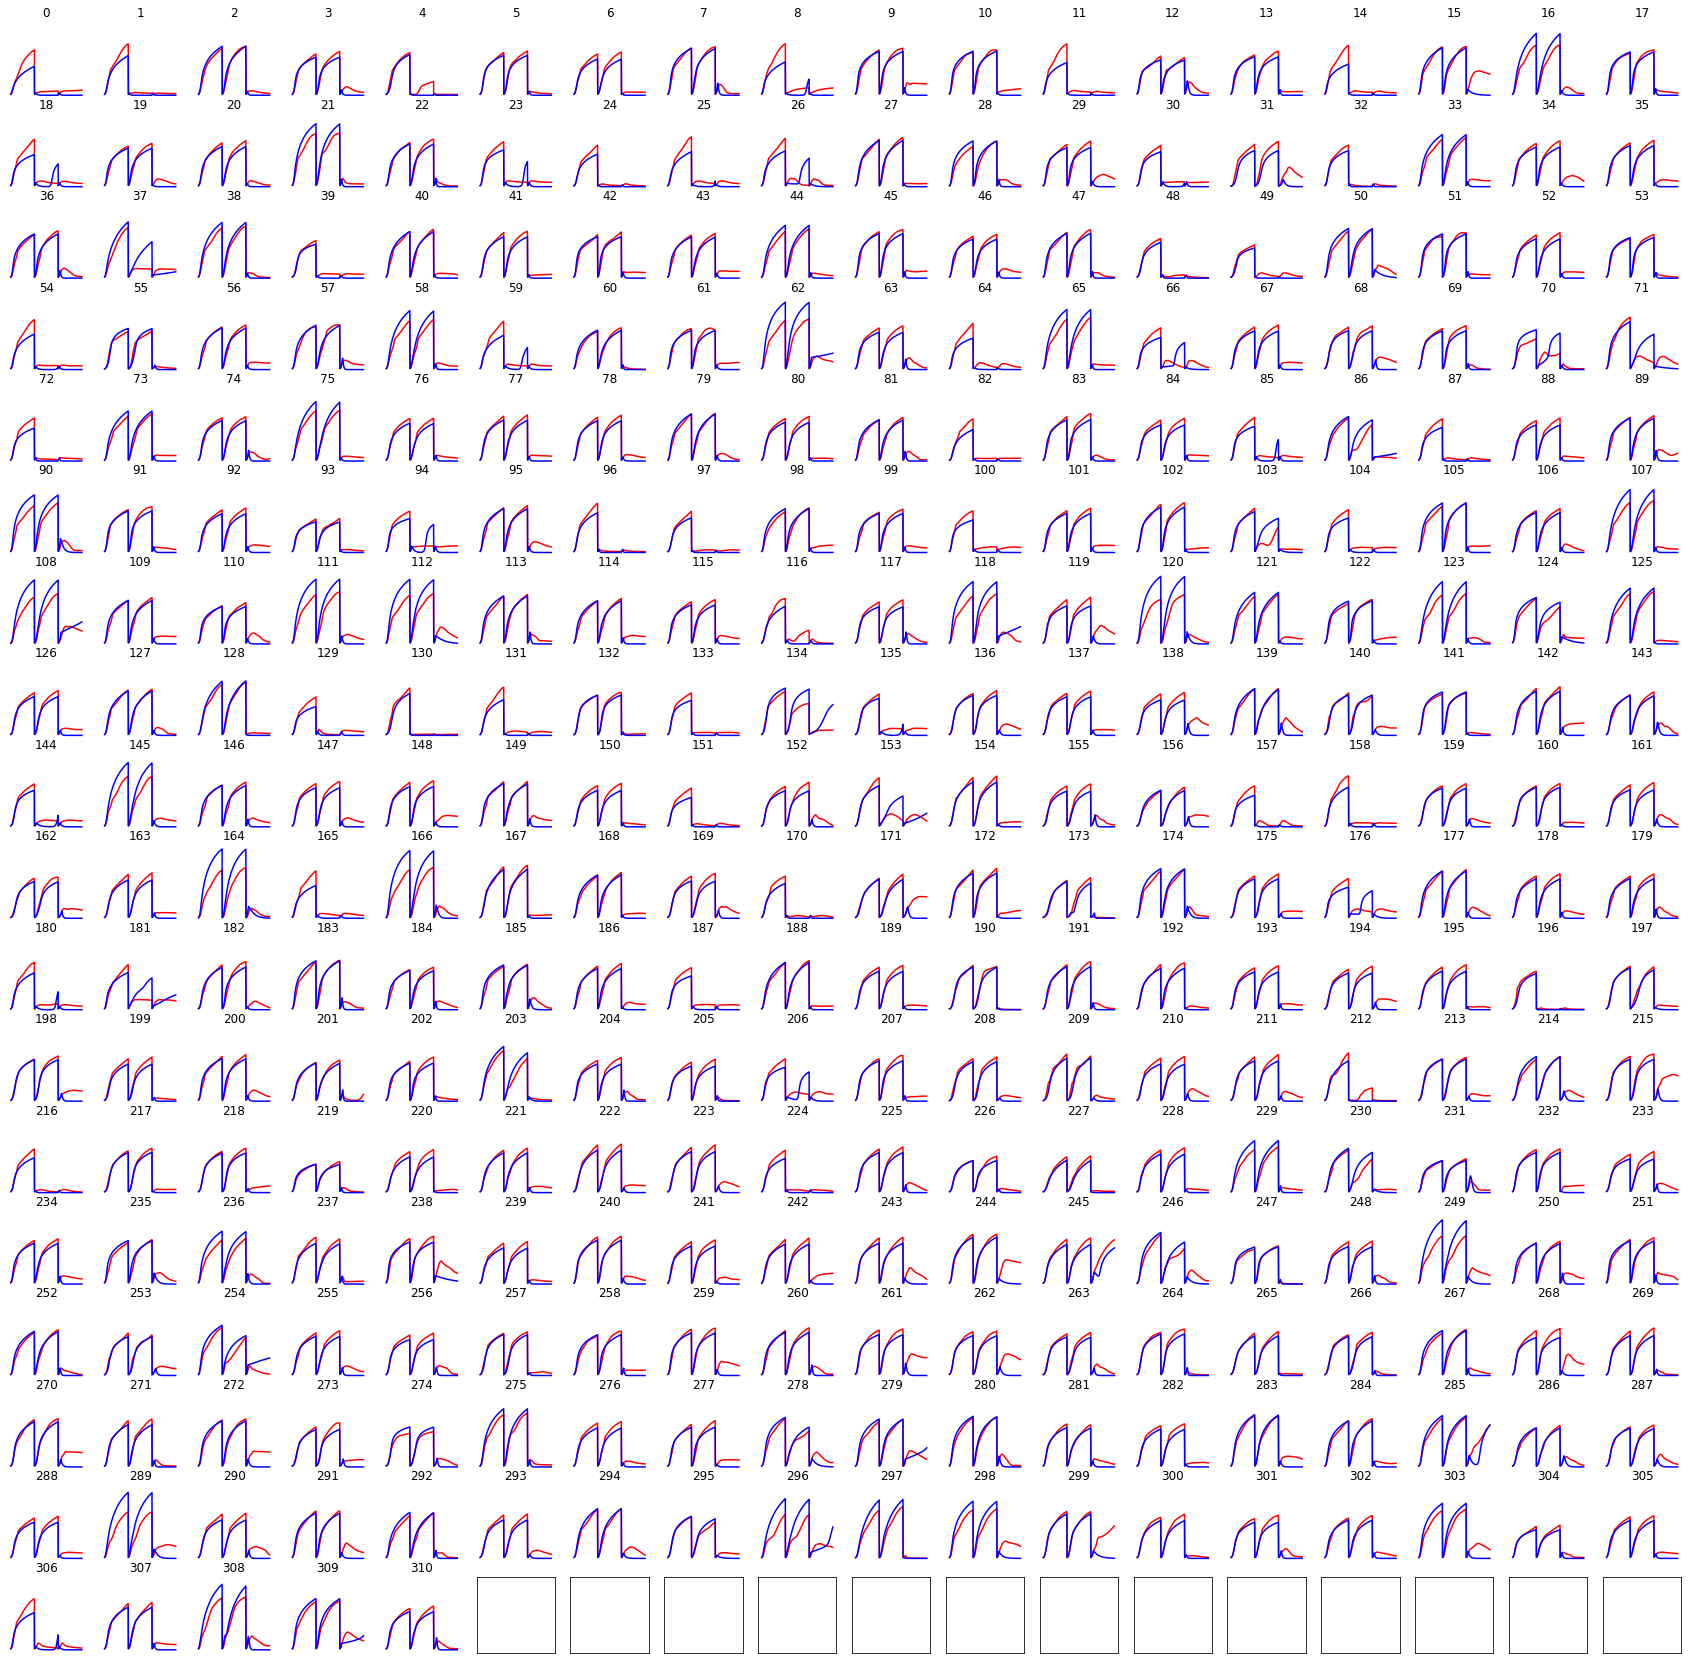

In [65]:
N_fig = 18
fig, axs = plt.subplots(N_fig,N_fig,figsize = (30,30), sharex = True, sharey = True, facecolor = 'white')
axs = axs.flatten()

for i in range(N_fig**2):
    
    j = i 
    
    if i >= Z.shape[0]:
        plt.show()
        break
        
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(j)    
    
    if i < Z.shape[0]:
        axs[i].plot(Z[j,:], color = 'red', label = "Experiment")
        axs[i].plot(predictions[j,:], color = 'blue', label = "Simulated")

    
fig.patch.set_facecolor('white')
plt.show()

In [22]:
Z.shape

(311, 435)

In [24]:
predictions.shape

(311, 435)

In [62]:
np.mean(np.abs(Z[:,0:145]-predictions[:,0:145])/(Z[:,0:145]))*100

14.514800147838145

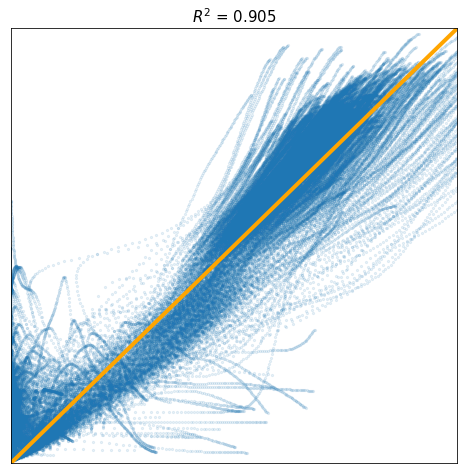

In [59]:
from scipy.stats import linregress

plt.figure(figsize = (8,8))
plt.plot([-2,3],[-2,3], color = 'orange', lw = 4 )
plt.xlim(Z.min(), Z.max())
plt.ylim(Z.min(), Z.max())
plt.xticks([])
plt.yticks([])

plt.scatter(predictions.flatten(), Z.flatten(), alpha = 0.1, s = 5)
_, _, rvalue, _, _ = linregress(predictions.flatten(), Z.flatten())

plt.title( f"$R^2$ = {np.around(rvalue**2, 3)}" , fontsize = 15)
plt.show()

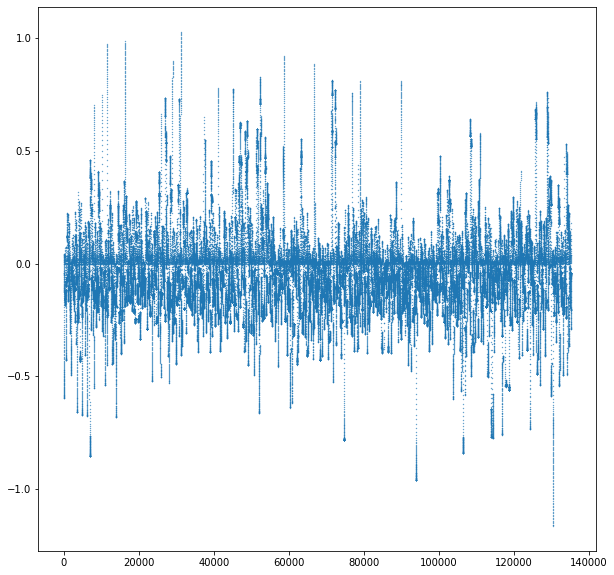

In [71]:
plt.figure(figsize = (10,10))
plt.scatter(np.arange(0, predictions.flatten().shape[0],1), predictions.flatten() - Z.flatten(), s = 0.1)
plt.show()